In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# import standard python packages
import sys
import numpy as np
# import basemap
from mpl_toolkits.basemap import Basemap
# import FESOM packages
sys.path.append("./modules/")
from load_mesh_data import *
sys.path.append("/home/h/hbkdsido/utils/seawater-1.1/")
import seawater as sw
from fesom_plot_tools import *
import cmocean.cm as cmo

In [3]:
# read the mesh
# set the path to the mesh
#meshpath  ='/home/ollie/nkolduno/meshes/pi-grid/'
meshpath  ='/work/ollie/dsidoren/input/fesom2.0/meshes/mesh_CORE2_final/'
alpha, beta, gamma=[50, 15, -90]
try:
	mesh
except NameError:
	print("mesh will be loaded")
	mesh=load_mesh(meshpath, abg=[alpha, beta, gamma], usepickle = False)
else:
	print("mesh with this name already exists and will not be loaded")

mesh will be loaded
Load 2d part of the grid in 1 second(s)


<IPython.core.display.Javascript object>


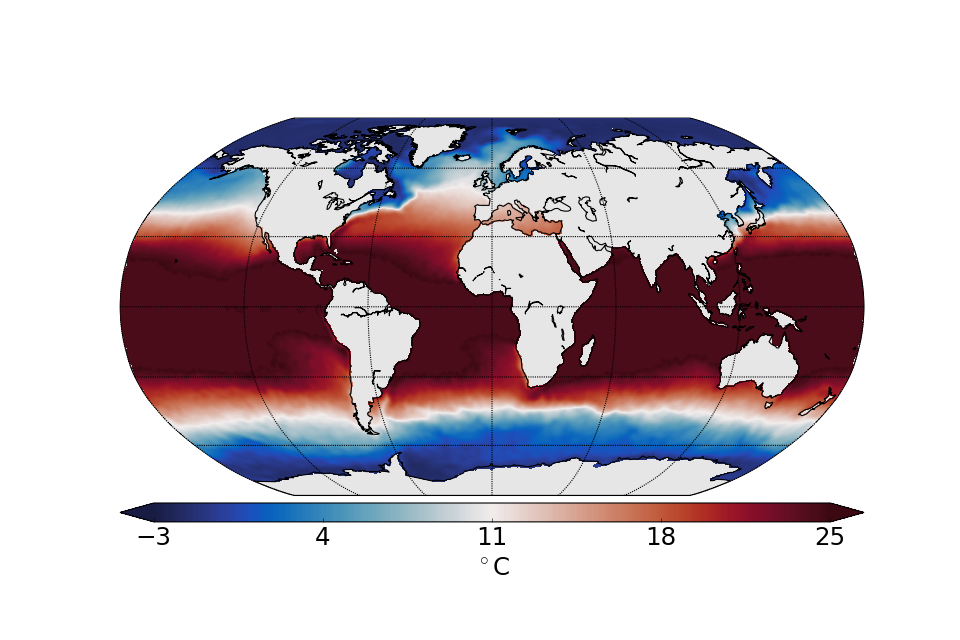

ftriplot, number of dummy points: 0


In [4]:
# Example 1: plot the 2D slice from data at depth
# set the paths etc. to the results
result_path ='../results/'
runid='fesom'
str_id='temp'
depth=0
ilev=ind_for_depth(depth, mesh)
# specify records and year to read
records, year=np.linspace(0,0,1).astype(int), 1948

# read the model result from fesom.XXXX.oce.nc
data=read_fesom_slice(str_id, records, year, mesh, result_path, runid, ilev=ilev)
# set the label for the colorbar & contour intervals for ftriplot
cbartext, cont = '$^\circ$C', [-3., 25., .1]
cmap=cmo.balance
fig = plt.figure(figsize=(12,8))
# ftriplot is defined in fesom_plot_tools.py
data[data==0]=np.nan
[im, map, cbar]=ftriplot(mesh, data, np.arange(cont[0], cont[1]+cont[2], cont[2]), oce='global', cmap=cmap)
cbar.set_label(cbartext, fontsize=22)
cbar.set_ticks([round(i,4) for i in np.linspace(cont[0], cont[1], 5)])
cbar.ax.tick_params(labelsize=22)

/home/ollie/dsidoren/miniconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/ollie/dsidoren/miniconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


the model depth is:  0 ; the closest depth in climatology is:  0.0


<IPython.core.display.Javascript object>


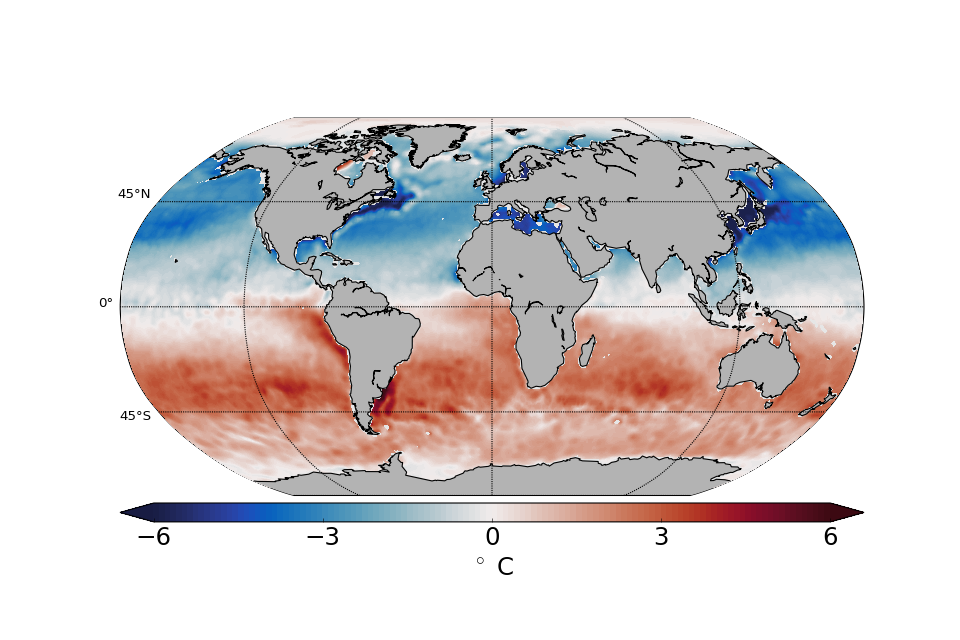

./modules/fesom_plot_tools.py:99: RuntimeWarning: invalid value encountered in less_equal
  zz[zz<=contours.min()]=contours.min()+eps
./modules/fesom_plot_tools.py:100: RuntimeWarning: invalid value encountered in greater_equal
  zz[zz>=contours.max()]=contours.max()-eps


In [33]:
# Example 2: comparing to climatology
# read the climatology first
from climatology import *
phc=climatology('phc3/', climname='phc')
# interpolate the data onto the climatology grig
[iz, xx, yy, zz]=fesom_2_clim(data, depth, mesh, phc, radius_of_influence=10000000)
# plot the difference to climatology
cbartext=('$^\circ$ C' if (str_id=='temp') else 'psu')
cont = [-6., 6., .1]
# compute the difference to climatology (only T & S are supported)
dd=zz[:,:]-(phc.T[iz,:,:] if (str_id=='temp') else phc.S[iz,:,:])

fig = plt.figure(figsize=(12,8))
[im, map, cbar]=wplot_xy(xx,yy,dd,np.arange(cont[0], cont[1]+cont[2], cont[2]), cmap=cmo.balance, do_cbar=True)
cbar.set_label(cbartext, fontsize=22)
cbar.set_ticks([round(i,4) for i in np.linspace(cont[0], cont[1], 5)])
cbar.ax.tick_params(labelsize=22)

<IPython.core.display.Javascript object>


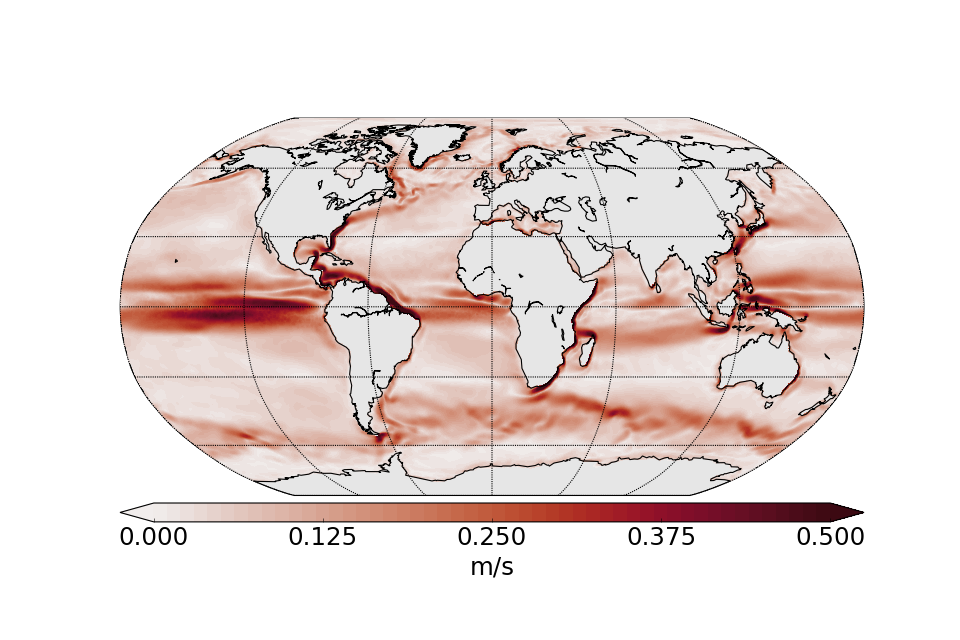

ftriplot, number of dummy points: 0


In [34]:
# Example 3: plot the norm of velocity (given on elements)
# read the ocean velocities
u=read_fesom_slice('u', records, year, mesh, result_path, runid, ilev=ilev)
v=read_fesom_slice('v', records, year, mesh, result_path, runid, ilev=ilev)
# interpolate them onto nodes
unodes=np.zeros(shape=mesh.n2d)
vnodes=np.zeros(shape=mesh.n2d)

var_elem=u*mesh.voltri
for i in range(mesh.e2d):
    unodes[mesh.elem[i,:]]=unodes[mesh.elem[i,:]]+[var_elem[i], var_elem[i], var_elem[i]]
unodes=unodes/mesh.lump2/3.

var_elem=v*mesh.voltri
for i in range(mesh.e2d):
    vnodes[mesh.elem[i,:]]=vnodes[mesh.elem[i,:]]+[var_elem[i], var_elem[i], var_elem[i]]
vnodes=vnodes/mesh.lump2/3.
data=np.hypot(unodes, vnodes)

# plot the result
# set the label for the colorbar & contour intervals for ftriplot
cbartext, cont = 'm/s', [0.,.5, 0.01]
cmap=cmo.amp
fig = plt.figure(figsize=(12,8))
# ftriplot is defined in fesom_plot_tools.py
data[data==0]=np.nan
[im, map, cbar]=ftriplot(mesh, data, np.arange(cont[0], cont[1]+cont[2], cont[2]), oce='global', cmap=cmap)
cbar.set_label(cbartext, fontsize=22)
cbar.set_ticks([round(i,4) for i in np.linspace(cont[0], cont[1], 5)])
cbar.ax.tick_params(labelsize=22)

/home/ollie/dsidoren/miniconda3/lib/python3.5/site-packages/pyresample/kd_tree.py:383: UserWarning: Possible more than 10 neighbours within 300000 m for some data points
  (neighbours, radius_of_influence))
/home/ollie/dsidoren/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


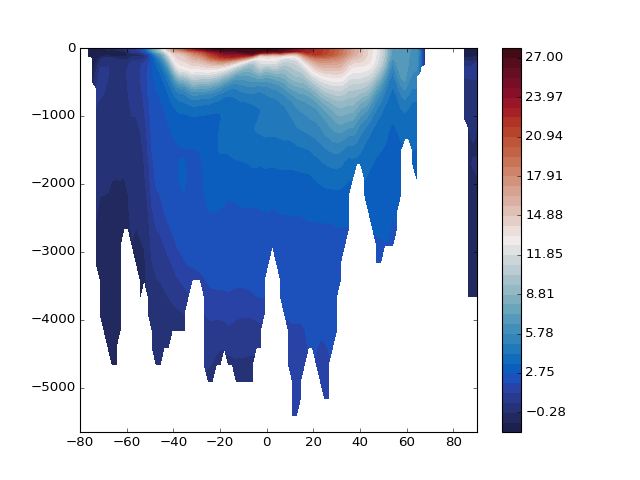

In [35]:
# Example 4: plot the section
# set the paths etc. to the results
# define the section with points p1, p2
p1=np.array([-30.,   -80.])
p2=np.array([-30.,    90.])
nxy=100
nz =46
[sx, sy, sz]=read_fesom_sect(str_id, records, year, mesh, result_path, runid, p1, p2, nxy, nz, \
    how='mean', line_distance=5., radius_of_influence=300000)
sz[sz>1.e100]=np.nan
# plot the result
cmap=cmo.balance
plt.figure()
plt.contourf(sy, mesh.zlev[0:nz], sz, cmap=cmap, levels=np.linspace(np.nanmin(sz), np.nanmax(sz), 40))
plt.colorbar()

0


/home/ollie/dsidoren/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


<IPython.core.display.Javascript object>


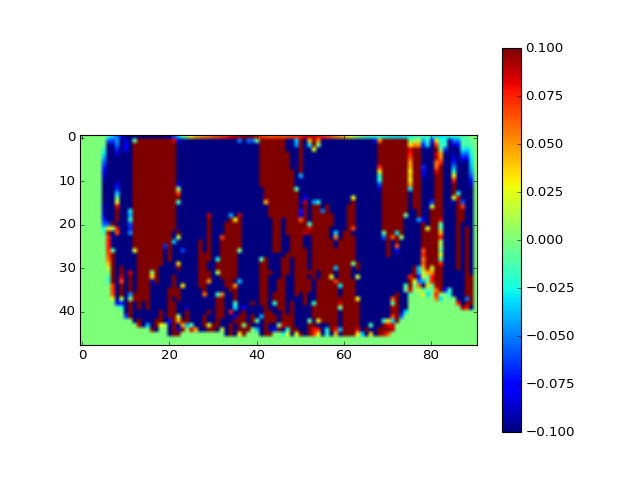

In [63]:
# Example 5: computing MOC from the vertical velocity
# a regular set of latitudes
nlats=91
lats=np.linspace(-90, 90, nlats)
dlat=lats[1]-lats[0]
moc=np.zeros([mesh.nlev, nlats])
#read the required metadata
ncfile  = Dataset(os.path.join(result_path, runid+'.mesh.diag.nc'))
el_area =ncfile.variables['elem_area'][:]
nlevels =ncfile.variables['nlevels'][:]-1
el_nodes=ncfile.variables['elem'][:,:]-1
nodes_x =ncfile.variables['nodes'][0,:]*180./np.pi
nodes_y =ncfile.variables['nodes'][1,:]*180./np.pi
elem_x  =nodes_x[el_nodes].sum(axis=0)/3.
elem_y  =nodes_y[el_nodes].sum(axis=0)/3.
# specify records and year to read
records, year=np.linspace(0,0,1).astype(int), 1948

pos=np.zeros([mesh.e2d])
for e in range(mesh.e2d):
    pos[e]=int((elem_y[e]-lats[0])/dlat)

for i in range(mesh.nlev):
# read the model result from fesom.XXXX.oce.nc
    w=read_fesom_slice('w', records, year, mesh, result_path, runid, ilev=i)
    print(i)
    for e in range(mesh.e2d):
        if (i <= nlevels[e]-1):
            moc[i, pos[e]]=moc[i, pos[e]]+el_area[e]*np.sum(w[el_nodes[:,e]])/3.*1.e-6
    
#for i in range(mesh.nlev)[1:]:
#    moc[i, :]=moc[i, :]+moc[i-1, :]
plt.figure()
plt.imshow(moc, vmin=-.1, vmax=.1)
plt.colorbar()

<IPython.core.display.Javascript object>


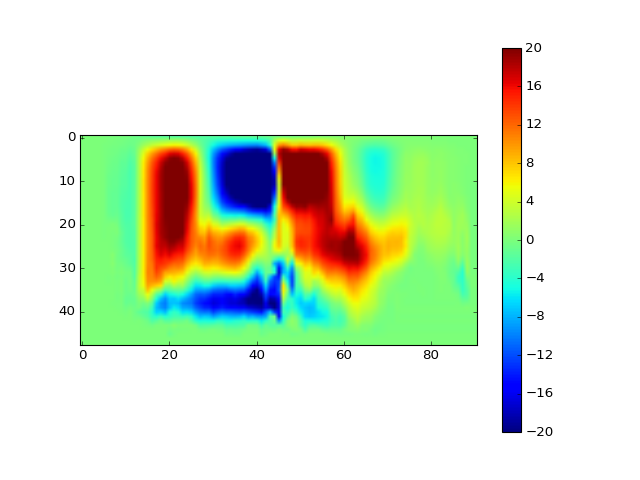

In [66]:
moc2=np.copy(moc)
for i in range(nlats):
    moc2[:, i]=moc2[:, i]+moc2[:, i-1]
plt.figure()
plt.imshow(moc2, vmin=-20, vmax=20)
plt.colorbar()